(6000, 28, 28) (60000,)
(6000, 28, 28) (10000,)
Model: "vae_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              multiple                  401920    
_________________________________________________________________
dense_6 (Dense)              multiple                  10260     
_________________________________________________________________
dense_7 (Dense)              multiple                  10260     
_________________________________________________________________
dense_8 (Dense)              multiple                  10752     
_________________________________________________________________
dense_9 (Dense)              multiple                  402192    
Total params: 835,384
Trainable params: 835,384
Non-trainable params: 0
_________________________________________________________________


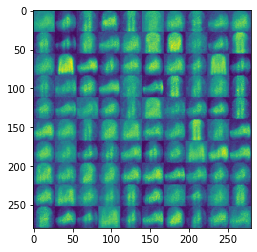

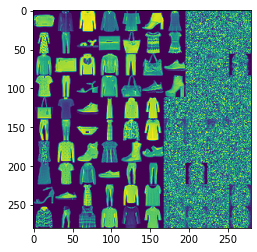

New images saved !


In [2]:
import  os
import  tensorflow as tf
import  numpy as np
from    tensorflow import keras
from    PIL import Image
from    matplotlib import pyplot as plt


tf.random.set_seed(22)
np.random.seed(22)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
assert tf.__version__.startswith('2.')




(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train, x_test = x_train[0:6000], x_test[0:6000]
x_train, x_test = x_train.astype(np.float32)/255., x_test.astype(np.float32)/255.



# In[19]:


print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


# image grid
new_im = Image.new('L', (280, 280))

image_size = 28*28
h_dim = 512
z_dim = 20
num_epochs = 1
batch_size = 128
learning_rate = 1e-3


class VAE(tf.keras.Model):

    def __init__(self):
        super(VAE, self).__init__()

        # input => h
        self.fc1 = keras.layers.Dense(h_dim)
        # h => mu and variance
        self.fc2 = keras.layers.Dense(z_dim)
        self.fc3 = keras.layers.Dense(z_dim)

        # sampled z => h
        self.fc4 = keras.layers.Dense(h_dim)
        # h => image
        self.fc5 = keras.layers.Dense(image_size)

    def encode(self, x):
        h = tf.nn.relu(self.fc1(x))
        # mu, log_variance
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        """
        reparametrize trick
        :param mu:
        :param log_var:
        :return:
        """
        std = tf.exp(log_var * 0.5)
        eps = tf.random.normal(std.shape)

        return mu + eps * std

    def decode_logits(self, z):
        h = tf.nn.relu(self.fc4(z))
        return self.fc5(h)

    def decode(self, z):
        return tf.nn.sigmoid(self.decode_logits(z))

    def call(self, inputs, training=None, mask=None):
        # encoder
        mu, log_var = self.encode(inputs)
        # sample
        z = self.reparameterize(mu, log_var)
        # decode
        x_reconstructed_logits = self.decode_logits(z)

        return x_reconstructed_logits, mu, log_var


model = VAE()
model.build(input_shape=(4, image_size))
model.summary()
optimizer = keras.optimizers.Adam(learning_rate)

# we do not need label
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(batch_size * 5).batch(batch_size)

num_batches = x_train.shape[0] // batch_size

for epoch in range(num_epochs):

    for step, x in enumerate(dataset):

        x = tf.reshape(x, [-1, image_size])

        with tf.GradientTape() as tape:

            # Forward pass
            x_reconstruction_logits, mu, log_var = model(x)

            # Compute reconstruction loss and kl divergence
            # For KL divergence, see Appendix B in VAE paper or http://yunjey47.tistory.com/43
            # Scaled by `image_size` for each individual pixel.
            reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_reconstruction_logits)
            reconstruction_loss = tf.reduce_sum(reconstruction_loss) / batch_size
            # please refer to
            # https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians
            kl_div = - 0.5 * tf.reduce_sum(1. + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
            kl_div = tf.reduce_mean(kl_div)

            # Backprop and optimize
            loss = tf.reduce_mean(reconstruction_loss) + kl_div

        gradients = tape.gradient(loss, model.trainable_variables)
        for g in gradients:
            tf.clip_by_norm(g, 15)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if (step + 1) % 50 == 0:
            print("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                  .format(epoch + 1, num_epochs, step + 1, num_batches, float(reconstruction_loss), float(kl_div)))



    # Generative model
    z = tf.random.normal((batch_size, z_dim))
    out = model.decode(z)  # decode with sigmoid
    out = tf.reshape(out, [-1, 28, 28]).numpy() * 255
    out = out.astype(np.uint8)


    # since we can not find image_grid function from vesion 2.0
    # we do it by hand.
    index = 0
    for i in range(0, 280, 28):
        for j in range(0, 280, 28):
            im = out[index]
            im = Image.fromarray(im, mode='L')
            new_im.paste(im, (i, j))
            index += 1

    new_im.save('images/vae_sampled_epoch_%d.png' % (epoch + 1))
    plt.imshow(np.asarray(new_im))
    plt.show()

    # Save the reconstructed images of last batch
    out_logits, _, _ = model(x[:batch_size // 2])
    out = tf.nn.sigmoid(out_logits)  # out is just the logits, use sigmoid
    out = tf.reshape(out, [-1, 28, 28]).numpy() * 255

    x = tf.reshape(x[:batch_size // 2], [-1, 28, 28])

    x_concat = tf.concat([x, out], axis=0).numpy() * 255.
    x_concat = x_concat.astype(np.uint8)

    index = 0
    for i in range(0, 280, 28):
        for j in range(0, 280, 28):
            im = x_concat[index]
            im = Image.fromarray(im, mode='L')
            new_im.paste(im, (i, j))
            index += 1

    new_im.save('images/vae_reconstructed_epoch_%d.png' % (epoch + 1))
    plt.imshow(np.asarray(new_im))
    plt.show()
    print('New images saved !')


